In [ ]:
import cv2
import os
from glob import glob
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator , img_to_array, load_img
from keras.utils import plot_model
from keras.optimizers import RMSprop
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications import ResNet50V2, MobileNetV2, ResNet101V2, EfficientNetB7
from keras.applications.efficientnet_v2 import EfficientNetV2M, EfficientNetV2L
from keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install rembg[gpu]
from rembg import remove
output = ["BGR","ORG","Crop"]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 KB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 KB

In [ ]:
# setting mode, images width and height parameters 
mode = "Crop"
IMAGE_HEIGHT_WIDTH = 350

In [ ]:
if (mode == "BGR"):
#Trainingset background removal
  directory1 ='/content/drive/MyDrive/Projects/GP Project/Dataset/TrainSet'
  new_created1 = '/content/drive/MyDrive/Projects/GP Project/Dataset/BgRemoved/Training'

  for filename in glob(f'{directory1}/*'):
    folder = os.path.basename(filename)
    try:
      path1 = os.path.join(new_created1, folder)
      os.makedirs(path1)  
      for image in glob(f'{filename}/*'):
          image_extend = os.path.basename(image)
          input_path = image
          output_path = os.path.join(path1, image_extend)
          input = Image.open(input_path)
          output = remove(input)
          output.save(output_path)
    except FileExistsError:
      # directory already exists
      pass

#validitionset background removal
  directory2 ='/content/drive/MyDrive/Projects/GP Project/Dataset/ValidationSet'
  new_created2 = '/content/drive/MyDrive/Projects/GP Project/Dataset/BgRemoved/Validation'

  for filename in glob(f'{directory2}/*'):
    folder = os.path.basename(filename)
    try:
      path2 = os.path.join(new_created2, folder)
      os.makedirs(path2)  
      for image in glob(f'{filename}/*'):
          image_extend = os.path.basename(image)
          input_path = image
          output_path = os.path.join(path2, image_extend)
          input = Image.open(input_path)
          output = remove(input)
          output.save(output_path)
    except FileExistsError:
      # directory already exists
      pass

#testset background removal
  directory3 ='/content/drive/MyDrive/Projects/GP Project/Dataset/TestSet'
  new_created3 = '/content/drive/MyDrive/Projects/GP Project/Dataset/BgRemoved/Testing'

  try:  
    os.makedirs(new_created3)  
    for image in glob("/content/drive/MyDrive/Projects/GP Project/Dataset/TestSet/*.png"):
        image_extend = os.path.basename(image)
        input_path = image
        output_path = os.path.join(new_created3, image_extend)
        input = Image.open(input_path)
        output = remove(input)
        output.save(output_path)
  except FileExistsError:
    # directory already exists
    pass

else: pass



In [ ]:
# setting vaules between 0 and 1 instead by scaling with a 1./255 factor
train = ImageDataGenerator(rescale = 1./255)
validation = ImageDataGenerator(rescale = 1./255)

if (mode == "ORG"):
  #training and validation with the original dataset
  train_dataset = train.flow_from_directory('/content/drive/MyDrive/Projects/GP Project/Dataset/TrainSet',
                                          target_size = (IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH),
                                          batch_size = 32,
                                          class_mode = "categorical")
  validation_dataset = validation.flow_from_directory('/content/drive/MyDrive/Projects/GP Project/Dataset/ValidationSet',
                                                    target_size = (IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH),
                                                    batch_size = 32,
                                                    class_mode = "categorical")
elif mode == "Crop":
    #training and validation with the cropped dataset
  train_dataset = train.flow_from_directory('/content/drive/MyDrive/Projects/GP Project/Dataset/croppedDatasetV2/trainSet',
                                          target_size = (IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH),
                                          batch_size = 32,
                                          class_mode = "categorical")
  validation_dataset = validation.flow_from_directory('/content/drive/MyDrive/Projects/GP Project/Dataset/croppedDatasetV2/validSet',
                                                    target_size = (IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH),
                                                    batch_size = 32,
                                                    class_mode = "categorical")
else:
  #training and validation with the background removal dataset
  train_dataset = train.flow_from_directory('/content/drive/MyDrive/Projects/GP Project/Dataset/BgRemoved/Training',
                                          target_size = (IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH),
                                          batch_size = 32,
                                          class_mode = "categorical")
  validation_dataset = validation.flow_from_directory('/content/drive/MyDrive/Projects/GP Project/Dataset/BgRemoved/Validation',
                                                    target_size = (IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH),
                                                    batch_size = 32,
                                                    class_mode = "categorical")

Found 900 images belonging to 15 classes.
Found 300 images belonging to 15 classes.


In [ ]:
#making a dictionary with each word in our dataset as a key
my_dic = dict(train_dataset.class_indices)
my_dic

{'drink': 0,
 'food': 1,
 'full': 2,
 'have': 3,
 'hello': 4,
 'i': 5,
 'i love you': 6,
 'police': 7,
 'prefer': 8,
 'shirt': 9,
 'telephone': 10,
 'water': 11,
 'wrong': 12,
 'yes': 13,
 'you': 14}

In [ ]:
#loading the folders of the validation set
if mode == "Crop":
  folders = glob('/content/drive/MyDrive/Projects/GP Project/Dataset/croppedDatasetV2/validSet/*')
elif mode == "ORG":
  folders = glob('/content/drive/MyDrive/Projects/GP Project/Dataset/ValidationSet/*')
else:
  folders = glob('/content/drive/MyDrive/Projects/GP Project/Dataset/BgRemoved/Validation/*')

# Model 1 VGG16

In [ ]:
#creating VGG16 model
vgg = VGG16(input_shape=(IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH,3), weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  
# our layers - you can add more if you want
x = Flatten()(vgg.output)

prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 350, 350, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 350, 350, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 175, 175, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 175, 175, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 175, 175, 128)     147584    
                                                              

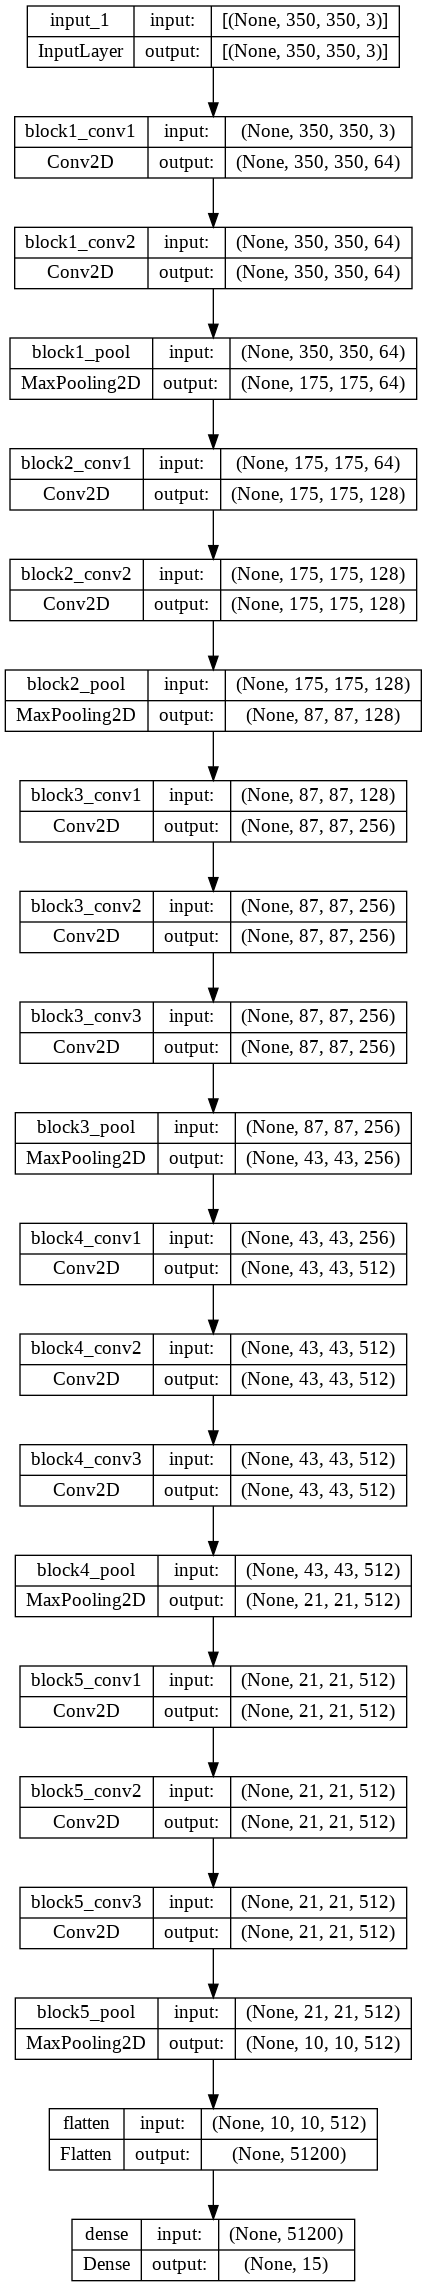

In [ ]:
#plotting model architecture
plot_model(model, to_file = 'VGG16_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
#Training VGG16 Model
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=8, callbacks=[checkpoint,early])

<ipython-input-13-a96624464737>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=8, callbacks=[checkpoint,early])


Epoch 1/8
29/29 [==============================] - ETA: 0s - loss: 1.6001 - accuracy: 0.6933
Epoch 1: val_accuracy improved from -inf to 0.81667, saving model to vgg16_1.h5
29/29 [==============================] - 25s 617ms/step - loss: 1.6001 - accuracy: 0.6933 - val_loss: 0.7056 - val_accuracy: 0.8167
Epoch 2/8
29/29 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9956
Epoch 2: val_accuracy improved from 0.81667 to 0.89000, saving model to vgg16_1.h5
29/29 [==============================] - 14s 492ms/step - loss: 0.0181 - accuracy: 0.9956 - val_loss: 0.4656 - val_accuracy: 0.8900
Epoch 3/8
29/29 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.89000
29/29 [==============================] - 14s 491ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.4048 - val_accuracy: 0.8833
Epoch 4/8
29/29 [==============================] - ETA: 0s - loss: 4.7397e-04 - accuracy: 1.0000
Epoch 4: val_a

In [ ]:
#saving the model
model.save('/content/drive/MyDrive/Projects/GP Project/Models/models_4/VGG16_Aug.h5')

# Model 2 VGG 19


In [ ]:
#creating VGG19 model
vgg1 = VGG19(input_shape=(IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH,3), weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg1.layers:
  layer.trainable = False
  
# our layers - you can add more if you want
x = Flatten()(vgg1.output)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model2 = Model(inputs=vgg1.input, outputs=prediction)

# view the structure of the model
model2.summary()

# tell the model what cost and optimization method to use
model2.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

80134624/80134624 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 350, 350, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 350, 350, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 175, 175, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 175, 175, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 175, 175, 128)     147584    
                                                            

In [ ]:
#plotting VGG19 architecture
#plot_model(model2, to_file = 'VGG19_model_structure_plot.png', show_shapes = True, show_layer_names = True);

In [ ]:
#training the model
hist2 = model2.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=8)

<ipython-input-17-008b1d9de4e5>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist2 = model2.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=8)


Epoch 1/8
29/29 [==============================] - 20s 687ms/step - loss: 1.6585 - accuracy: 0.6800 - val_loss: 0.8030 - val_accuracy: 0.7800
Epoch 2/8
29/29 [==============================] - 19s 657ms/step - loss: 0.0373 - accuracy: 0.9878 - val_loss: 0.4537 - val_accuracy: 0.9000
Epoch 3/8
29/29 [==============================] - 19s 660ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.4957 - val_accuracy: 0.8633
Epoch 4/8
29/29 [==============================] - 19s 661ms/step - loss: 6.6165e-04 - accuracy: 1.0000 - val_loss: 0.4247 - val_accuracy: 0.8833
Epoch 5/8
29/29 [==============================] - 19s 659ms/step - loss: 4.3024e-04 - accuracy: 1.0000 - val_loss: 0.4029 - val_accuracy: 0.8900
Epoch 6/8
29/29 [==============================] - 19s 663ms/step - loss: 3.6414e-04 - accuracy: 1.0000 - val_loss: 0.4094 - val_accuracy: 0.8900
Epoch 7/8
29/29 [==============================] - 19s 668ms/step - loss: 3.2744e-04 - accuracy: 1.0000 - val_loss: 0.4106 - val_accurac

In [ ]:
#saving the model
model2.save('/content/drive/MyDrive/Projects/GP Project/Models/models_4/VGG19_Aug.h5')

# Model 3 ResNetV2 50

In [ ]:
#creating Resnet50v2 model
res = ResNet50V2(include_top=False, weights="imagenet",input_shape=(IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH,3))

for layer in res.layers:
  layer.trainable = False  

# our layers - you can add more if you want
x = Flatten()(res.output)
predictions = Dense(len(folders), activation='softmax')(x)

# create a model object
model3 = Model(inputs = res.input, outputs = predictions)

# view the structure of the model
model3.summary()

# tell the model what cost and optimization method to use
model3.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 350, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 356, 356, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 175, 175, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
#training the model
hist3 = model3.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=8)

<ipython-input-20-3203192e53eb>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist3 = model3.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=8)


Epoch 1/8
29/29 [==============================] - 17s 406ms/step - loss: 3.6557 - accuracy: 0.8311 - val_loss: 5.3754 - val_accuracy: 0.8300
Epoch 2/8
29/29 [==============================] - 9s 308ms/step - loss: 0.2101 - accuracy: 0.9844 - val_loss: 5.6987 - val_accuracy: 0.8800
Epoch 3/8
29/29 [==============================] - 9s 305ms/step - loss: 0.0761 - accuracy: 0.9956 - val_loss: 4.0773 - val_accuracy: 0.8733
Epoch 4/8
29/29 [==============================] - 9s 303ms/step - loss: 0.0019 - accuracy: 0.9989 - val_loss: 3.0943 - val_accuracy: 0.8867
Epoch 5/8
29/29 [==============================] - 9s 304ms/step - loss: 8.9809e-06 - accuracy: 1.0000 - val_loss: 4.1809 - val_accuracy: 0.8733
Epoch 6/8
29/29 [==============================] - 9s 302ms/step - loss: 2.9997e-07 - accuracy: 1.0000 - val_loss: 4.2317 - val_accuracy: 0.8767
Epoch 7/8
29/29 [==============================] - 9s 300ms/step - loss: 7.9473e-10 - accuracy: 1.0000 - val_loss: 4.2347 - val_accuracy: 0.8767


In [ ]:
#saving the model
model3.save('/content/drive/MyDrive/Projects/GP Project/Models/models_4/res50V2_Aug.h5')

# Model 4 MobileNetV2

In [ ]:
#creating MobilenetV2 model
mobile = MobileNetV2(input_shape=(IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH,3), weights='imagenet', include_top=False)

# don't train existing weights
for layer in mobile.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(mobile.output)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model4 = Model(inputs=mobile.input, outputs=prediction)

# view the structure of the model
model4.summary()

# tell the model what cost and optimization method to use
model4.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

9406464/9406464 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 350, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 175, 175, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 175, 175, 32  128         ['Conv1[0][0]']                  
                             

In [ ]:
#training the model
hist4 = model4.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=8)

<ipython-input-23-9c4c5885c44e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist4 = model4.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=8)


Epoch 1/8
29/29 [==============================] - 10s 240ms/step - loss: 3.3674 - accuracy: 0.8111 - val_loss: 5.7648 - val_accuracy: 0.8433
Epoch 2/8
29/29 [==============================] - 6s 190ms/step - loss: 0.2078 - accuracy: 0.9878 - val_loss: 1.6028 - val_accuracy: 0.9267
Epoch 3/8
29/29 [==============================] - 5s 185ms/step - loss: 0.0601 - accuracy: 0.9944 - val_loss: 1.7467 - val_accuracy: 0.8767
Epoch 4/8
29/29 [==============================] - 5s 188ms/step - loss: 0.0209 - accuracy: 0.9944 - val_loss: 2.8657 - val_accuracy: 0.8900
Epoch 5/8
29/29 [==============================] - 6s 216ms/step - loss: 0.0132 - accuracy: 0.9989 - val_loss: 3.0442 - val_accuracy: 0.8933
Epoch 6/8
29/29 [==============================] - 6s 196ms/step - loss: 0.0283 - accuracy: 0.9989 - val_loss: 2.5804 - val_accuracy: 0.9200
Epoch 7/8
29/29 [==============================] - 5s 187ms/step - loss: 3.9736e-09 - accuracy: 1.0000 - val_loss: 2.5707 - val_accuracy: 0.9200
Epoch 8/

In [ ]:
#saving the model
model4.save('/content/drive/MyDrive/Projects/GP Project/Models/models_4/mobileV2_Aug.h5')

# Model 5 ResnetV2 101

In [ ]:
#creating Resnet101V2 model
res1 = ResNet101V2(include_top=False, weights="imagenet",input_shape=(IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH,3))

for layer in res1.layers:
  layer.trainable = False  

# our layers - you can add more if you want
x = Flatten()(res1.output)
predictions = Dense(len(folders), activation='softmax')(x)

# create a model object
model5 = Model(inputs = res1.input, outputs = predictions)

# view the structure of the model
model5.summary()

# tell the model what cost and optimization method to use
model5.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 350, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 356, 356, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 175, 175, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
#training the model
hist5 = model.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=8)

<ipython-input-26-5c3a1d30e576>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist5 = model.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=8)


Epoch 1/8
29/29 [==============================] - 17s 584ms/step - loss: 1.7024e-04 - accuracy: 1.0000 - val_loss: 0.3290 - val_accuracy: 0.8867
Epoch 2/8
29/29 [==============================] - 16s 564ms/step - loss: 1.5853e-04 - accuracy: 1.0000 - val_loss: 0.3256 - val_accuracy: 0.8967
Epoch 3/8
29/29 [==============================] - 16s 556ms/step - loss: 1.4868e-04 - accuracy: 1.0000 - val_loss: 0.3223 - val_accuracy: 0.8967
Epoch 4/8
29/29 [==============================] - 16s 550ms/step - loss: 1.3946e-04 - accuracy: 1.0000 - val_loss: 0.3171 - val_accuracy: 0.8967
Epoch 5/8
29/29 [==============================] - 16s 551ms/step - loss: 1.3180e-04 - accuracy: 1.0000 - val_loss: 0.3175 - val_accuracy: 0.8900
Epoch 6/8
29/29 [==============================] - 16s 555ms/step - loss: 1.2439e-04 - accuracy: 1.0000 - val_loss: 0.3154 - val_accuracy: 0.8900
Epoch 7/8
29/29 [==============================] - 16s 559ms/step - loss: 1.1780e-04 - accuracy: 1.0000 - val_loss: 0.3127 -

In [ ]:
#saving the model
model5.save('/content/drive/MyDrive/Projects/GP Project/Models/models_4/res101V2_Aug.h5')

# Model 6 EffcientNetB7

In [ ]:
#creating EffcientnetB7 model
b7 = EfficientNetB7(include_top=False, weights="imagenet",input_shape=(IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH,3))

for layer in b7.layers:
  layer.trainable = False  

# our layers - you can add more if you want
x = Flatten()(b7.output)
predictions = Dense(len(folders), activation='softmax')(x)

# create a model object
model10 = Model(inputs = b7.input, outputs = predictions)

# view the structure of the model
model10.summary()

# tell the model what cost and optimization method to use
model10.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 350, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 350, 350, 3)  0           ['input_9[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 350, 350, 3)  7          ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
#training the model
hist6 = model10.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=25)

<ipython-input-44-9fc28cdfd247>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist6 = model10.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=25)


Epoch 1/25
29/29 [==============================] - 59s 1s/step - loss: 275.8590 - accuracy: 0.0633 - val_loss: 194.1073 - val_accuracy: 0.0667
Epoch 2/25
29/29 [==============================] - 34s 1s/step - loss: 114.0945 - accuracy: 0.0578 - val_loss: 104.0416 - val_accuracy: 0.0667
Epoch 3/25
29/29 [==============================] - 34s 1s/step - loss: 96.7671 - accuracy: 0.0733 - val_loss: 114.0488 - val_accuracy: 0.0667
Epoch 4/25
29/29 [==============================] - 34s 1s/step - loss: 89.1577 - accuracy: 0.0611 - val_loss: 38.8240 - val_accuracy: 0.0367
Epoch 5/25
29/29 [==============================] - 34s 1s/step - loss: 52.9727 - accuracy: 0.0933 - val_loss: 53.0496 - val_accuracy: 0.1133
Epoch 6/25
29/29 [==============================] - 36s 1s/step - loss: 60.1636 - accuracy: 0.0800 - val_loss: 105.9130 - val_accuracy: 0.0667
Epoch 7/25
29/29 [==============================] - 36s 1s/step - loss: 76.6682 - accuracy: 0.1311 - val_loss: 53.6997 - val_accuracy: 0.0767


In [ ]:
#saving the model
model10.save('/content/drive/MyDrive/Projects/GP Project/Models/models_4/effcientb7_Aug.h5')

# Model 7 EffcientNetV2M

In [ ]:
#creating EffcientnetV2M model
evm = EfficientNetV2M(include_top=False, weights="imagenet",input_shape=(IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH,3))

for layer in evm.layers:
  layer.trainable = False  

# our layers - you can add more if you want
x = Flatten()(evm.output)
predictions = Dense(len(folders), activation='softmax')(x)

# create a model object
model7 = Model(inputs = evm.input, outputs = predictions)

# view the structure of the model
model7.summary()

# tell the model what cost and optimization method to use
model7.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 350, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 350, 350, 3)  0           ['input_7[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 175, 175, 24  648         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

In [ ]:
#training the model
hist7 = model7.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=25)

<ipython-input-32-d85625a7fa64>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist7 = model7.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=25)


Epoch 1/25
29/29 [==============================] - 46s 895ms/step - loss: 140.9861 - accuracy: 0.0722 - val_loss: 124.5801 - val_accuracy: 0.0667
Epoch 2/25
29/29 [==============================] - 20s 705ms/step - loss: 68.5341 - accuracy: 0.0767 - val_loss: 54.1017 - val_accuracy: 0.0667
Epoch 3/25
29/29 [==============================] - 20s 687ms/step - loss: 44.0188 - accuracy: 0.0900 - val_loss: 33.6579 - val_accuracy: 0.1133
Epoch 4/25
29/29 [==============================] - 19s 668ms/step - loss: 37.2567 - accuracy: 0.1089 - val_loss: 32.9402 - val_accuracy: 0.0667
Epoch 5/25
29/29 [==============================] - 19s 672ms/step - loss: 39.8970 - accuracy: 0.0878 - val_loss: 55.3861 - val_accuracy: 0.0667
Epoch 6/25
29/29 [==============================] - 20s 689ms/step - loss: 47.7976 - accuracy: 0.0778 - val_loss: 50.8110 - val_accuracy: 0.0667
Epoch 7/25
29/29 [==============================] - 20s 688ms/step - loss: 44.2403 - accuracy: 0.0889 - val_loss: 43.5960 - val_

In [ ]:
#saving the model
model7.save('/content/drive/MyDrive/Projects/GP Project/Models/models_4/effcientV2M_Aug.h5')

# Model 8 EffcientNetV2L

In [ ]:
#creating EffcientnetV2L model
evl = EfficientNetV2L(include_top=False, weights="imagenet",input_shape=(IMAGE_HEIGHT_WIDTH,IMAGE_HEIGHT_WIDTH,3))

for layer in evl.layers:
  layer.trainable = False  

# our layers - you can add more if you want
x = Flatten()(evl.output)
predictions = Dense(len(folders), activation='softmax')(x)

# create a model object
model8 = Model(inputs = evl.input, outputs = predictions)

# view the structure of the model
model8.summary()

# tell the model what cost and optimization method to use
model8.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 350, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 350, 350, 3)  0           ['input_8[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 175, 175, 32  864         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                            

In [ ]:
#training the model
hist8 = model8.fit_generator(steps_per_epoch=len(train_dataset), generator=train_dataset, validation_data=validation_dataset, validation_steps=len(validation_dataset), epochs=25)

In [ ]:
#saving the model
model8.save('/content/drive/MyDrive/Projects/GP Project/Models/models_4/effcientV2L_Aug.h5')

# Models Comparison

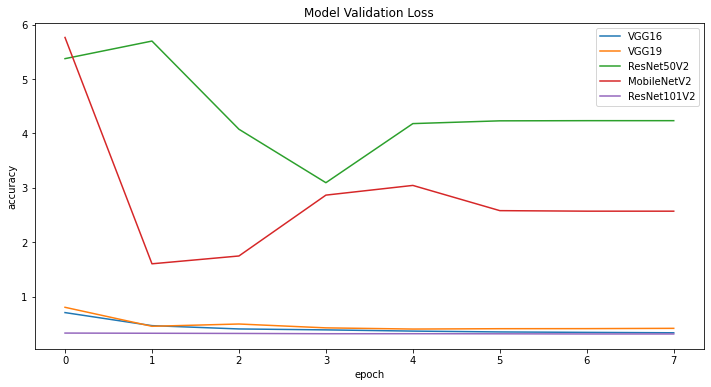

In [ ]:
# plotting Validation Loss comparison between 8 epoch models
plt.figure(figsize=(12,6)) 
plt.plot(hist.history['val_loss'])
plt.plot(hist2.history['val_loss'])
plt.plot(hist3.history['val_loss'])
plt.plot(hist4.history['val_loss'])
plt.plot(hist5.history['val_loss'])

plt.title('Model Validation Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['VGG16', 'VGG19',"ResNet50V2","MobileNetV2","ResNet101V2"])
plt.show()

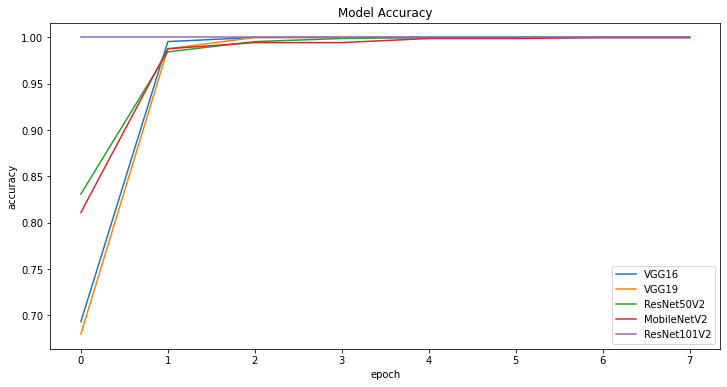

In [ ]:
# plotting Accuracy comparison between 8 epochs models
plt.figure(figsize=(12,6)) 
plt.plot(hist.history['accuracy'])
plt.plot(hist2.history['accuracy'])
plt.plot(hist3.history['accuracy'])
plt.plot(hist4.history['accuracy'])
plt.plot(hist5.history['accuracy'])

plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['VGG16', 'VGG19',"ResNet50V2","MobileNetV2","ResNet101V2"])
plt.show()

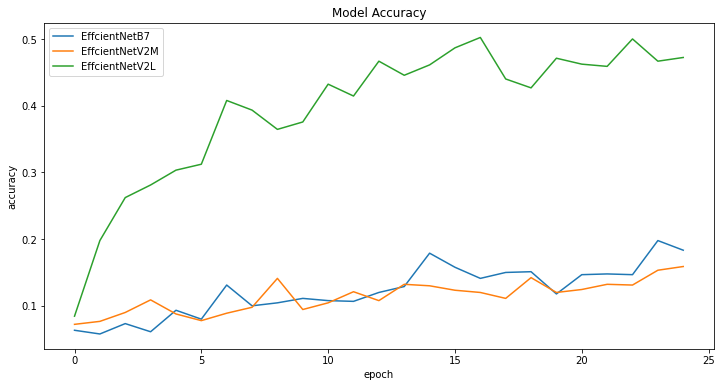

In [ ]:
# plotting Accuracy comparison between 25 epochs models
plt.figure(figsize=(12,6)) 
plt.plot(hist6.history['accuracy'])
plt.plot(hist7.history['accuracy'])
plt.plot(hist8.history['accuracy'])

plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['EffcientNetB7', 'EffcientNetV2M',"EffcientNetV2L"])
plt.show()

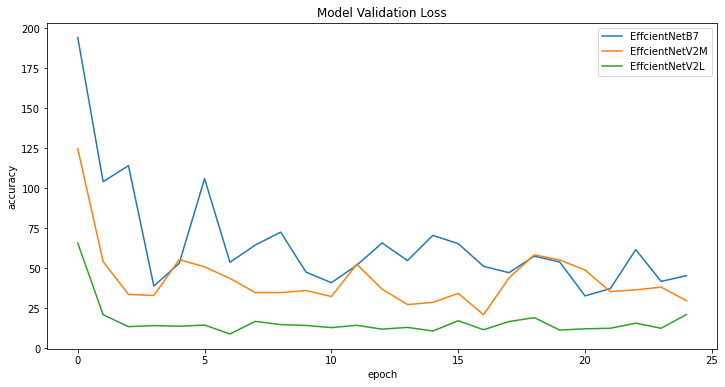

In [ ]:
# plotting Validation Loss comparison between 25 epochs models
plt.figure(figsize=(12,6)) 
plt.plot(hist6.history['val_loss'])
plt.plot(hist7.history['val_loss'])
plt.plot(hist8.history['val_loss'])

plt.title('Model Validation Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['EffcientNetB7', 'EffcientNetV2M',"EffcientNetV2L"])
plt.show()

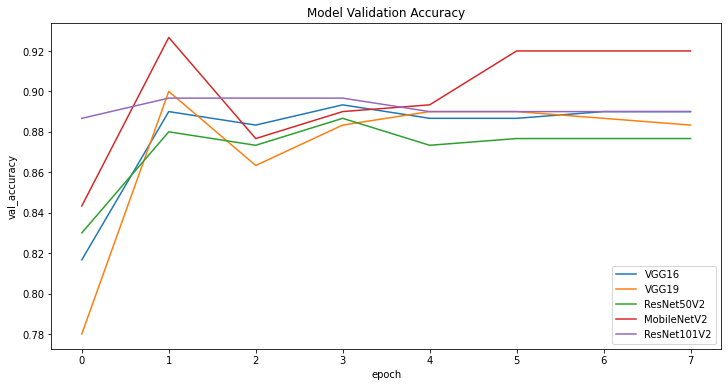

In [ ]:
# plotting Validation Accuracy comparison between 8 epochs models
plt.figure(figsize=(12,6)) 
plt.plot(hist.history['val_accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.plot(hist4.history['val_accuracy'])
plt.plot(hist5.history['val_accuracy'])

plt.title('Model Validation Accuracy')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['VGG16', 'VGG19',"ResNet50V2","MobileNetV2","ResNet101V2"])
plt.show()

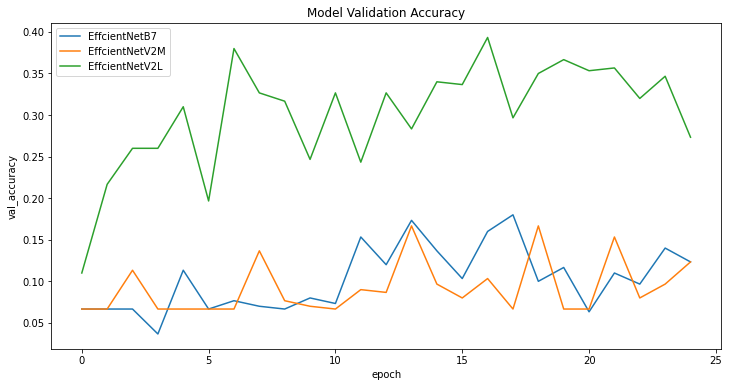

In [ ]:
# plotting Validation Accuracy comparison between 25 epochs models
plt.figure(figsize=(12,6)) 
plt.plot(hist6.history['val_accuracy'])
plt.plot(hist7.history['val_accuracy'])
plt.plot(hist8.history['val_accuracy'])

plt.title('Model Validation Accuracy')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['EffcientNetB7', 'EffcientNetV2M',"EffcientNetV2L"])
plt.show()